## Global Navigation

The goal of this part is to create a trajectory that will allow the Thymio to pass through several interest point and come back to his initial position.

The trajectory has to ensure that the Thymio avoid the global obstacles detected by the camera.

### Pass planning : Process flow

The creation of our trajectory is composed of the following steps :

- Dilatation of the obstacles to avoid collisions.

- Visibility graph computation by using the previously dilated obstacles.

- Pass planning computation by using the visibility graph and the interest point positions.

#### Obstacle dilatation

To perform the obstacle dilatation, we have implemented two different algorithms in parallel with the aim of taking the one that will provide the best results.

The first algorithm that we used is based on the dilatation function provided in the OpenCV library :

- Find the contours of the global obstacles.

- Create a grayscale image with the global obstacles in white and the rest in black.

- Dilate the global obstacles in this image.

- Find the new dilated contours.

For more details on the OpenCV dilatation function, see [Morphological transformations in OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html).

In [23]:
import cv2
import sys
import numpy as np

sys.path.append("../vision")

from vision import *

In [40]:
#RED_LOW  = [150, 100, 100]
#RED_HIGH = [179, 255, 255]

#DIL_COEFF_K = 15


def detect_obstacles(frame, scale=1):
    
    # Find the contours of the global obstacles
    frame = frame.copy()
    red_low = np.array(RED_LOW, np.uint8)
    red_high = np.array(RED_HIGH, np.uint8)
    
    clean_contours = find_color(frame, red_low, red_high)
    
    
    # Some operations used for plotting purposes and scalling of the image in real dimmensions
    cv2.drawContours(frame, clean_contours, -1, (0,255,0), 3)
            
    original_contours = []
    for cnt in clean_contours:
        ocnt = []
        for pt in cnt:
            ocnt.append(pt[0])
        original_contours.append(np.multiply(ocnt, scale).astype(int))
        
        
    # Create a grayscale image with the global obstacles in white and the rest in black
    black = np.zeros(frame.shape[:2], dtype=np.uint8)
    
    for i in range(len(clean_contours)):
        cv2.drawContours(black, clean_contours, i, (255), -1)

    plt.figure()
    plt.imshow(black, cmap="gray")
    
    
    # Dilate the global obstacles in this image
    kernel = np.ones((DIL_COEFF_K,DIL_COEFF_K),np.uint8)
    black = cv2.dilate(black, kernel, iterations = 15)

    plt.figure()
    plt.imshow(black, cmap="gray")
    
    
    # Find the new dilated contours
    contours, hierarchy = cv2.findContours(black, cv2.RETR_EXTERNAL  , cv2.CHAIN_APPROX_SIMPLE)
    
    clean_dil_contours = cleanup_contours(contours, 1)

    
    # Some operations used for plotting purposes and scalling of the image in real dimmensions
    scaled_contours = []
    for cnt in clean_dil_contours:
        ncnt = []
        for pt in cnt:
            frame = cv2.circle(frame, (pt[0][0], pt[0][1]), radius=5, color=(0, 0, 255), thickness=-1)
            ncnt.append(pt[0])

        scaled_contours.append(np.multiply(ncnt, scale).astype(int))
    
    
    return scaled_contours, original_contours, frame

To see the result of our algorithm, we will use the following function (note that this function will be also used to plot other results computed in the global Navigation part) :

In [41]:
import matplotlib.pyplot as plt

In [42]:
X = 0
Y = 1

def printGlobalNavigation(contours, contoursMapped, possibleDisplacement = {}, interestPoints = [], trajectory = []):
    """Plot the original contours and the dilated contours using matplotlib
       Plot the visibility graph if possibleDisplacement is given 
       Plot the Thymio's point of interest if interestPoints is given
       Plot the Thymio's path if the trajectory is given

    Parameters
    ----------
    contours : list of list of list
        The camera detect several obstacles
        Each obstacle has several extremities
        Each extremity has (x, y) coordinates

    contoursMapped : list of list of list
        Same structure as contours, each extremity's coordinate has been dilated

    possibleDispacement : dictionary
        Each extremity point has several visible points, i.e possible destinations for the Thymio

    interestPoints : list of list
        Each point of interest has (x, y) coordinates, i.e locations where the thymio need to go

    trajectory : list of list
        Each point of the trajectory has (x, y) coordinates

    Returns
    -------

    """

    xOriginal = []
    yOriginal = []
    xDilated = []
    yDilated = []

    for obstacleOriginal in contours:
        for extremityOriginal in obstacleOriginal:
            xOriginal.append(extremityOriginal[X])
            yOriginal.append(extremityOriginal[Y])

        xOriginal.append(obstacleOriginal[0][X])
        yOriginal.append(obstacleOriginal[0][Y])

        plt.plot(xOriginal, yOriginal, 'b')

        xOriginal.clear()
        yOriginal.clear()

    
    for obstacleDilated in contoursMapped:
        for extremityDilated in obstacleDilated:
            xDilated.append(extremityDilated[X])
            yDilated.append(extremityDilated[Y])

        xDilated.append(obstacleDilated[0][X])
        yDilated.append(obstacleDilated[0][Y])

        plt.plot(xDilated, yDilated, 'm')

        xDilated.clear()
        yDilated.clear()


    if possibleDisplacement:
        for extremity in possibleDisplacement:
            for visiblePoint in possibleDisplacement[extremity]:
                plt.plot([extremity[X], visiblePoint[X]], [extremity[Y], visiblePoint[Y]], 'm')

    
    if interestPoints:
        for point in interestPoints:
            plt.plot([point[X]], [point[Y]], 'kx', markersize=12)


    if trajectory:
        for i in range (1, len(trajectory)):
            plt.arrow(trajectory[i-1][X], trajectory[i-1][Y], trajectory[i][X] - trajectory[i-1][X], trajectory[i][Y] - trajectory[i-1][Y], head_width=8, length_includes_head=True, color  = 'k', width = 2)

    plt.show()

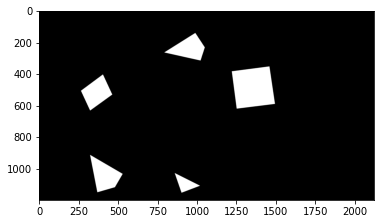

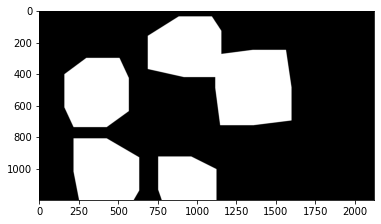

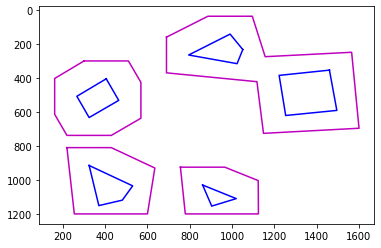

In [43]:
frame = cv2.imread("../vision/images/colors.png")

# Dilate obstacles and print them
scaled_contours, original_contours, ret = detect_obstacles(frame)

plt.figure()
plt.gca().invert_yaxis()
printGlobalNavigation(original_contours, scaled_contours)

ICI MONTRER L'AUTRE METHODE

#### Visibility graph computation

##### Naive algorithm

Reference : [Naive visibility graph algorithm](https://taipanrex.github.io/2016/09/17/Distance-Tables-Part-1-Defining-the-Problem.html)

Computational Geometry defines visibility graphs in the following way: Given a set $S$ of disjoint polygonal obstacles, we denote the visibility graph $G_{vis}(S)$. It’s nodes are the vertices of $S$ and there is an arc between vertices $v$ and $w$ if they can see each other, that is, if the segment $\overline{vw}$ does not intersect the interior of any obstacle in $S$.

Here is the algorithm :

To build the visibility graph naïvely, we add all the vertices from our set of obstacles to visibility graph G. For each vertex v in G, we check it against all the other vertices in G to see which vertices are visible to v. To check if a vertex w is visible, we need to check if the arc/edge from v to w intersects with any of the edges of the obstacles. If it doesn’t intersect any edges, v is visible to w and vice versa. There is no obstacle blocking the view between v and w and it can be used as part of a path.

The issue with the naïve algorithm is that it’s time complexity is $O(n^3)$. A better algorithm is the D.T.Lee's visibility graph algorithm which runs in $O(n^2log_2n)$.

###### Lee's visibility graph algorithm

Reference : [Lee's visibility graph algorithm](https://taipanrex.github.io/2016/10/19/Distance-Tables-Part-2-Lees-Visibility-Graph-Algorithm.html)

We are still going to need the first two for loops as in the naïve solution detailed in the previous part. Lee’s approach saves us running time by reducing the number of edges we need to check for each pair of points. That part of Lee’s algorithm runs in $O(log_2n)$ time, leaving a total running time of $O(n^2log_2n)$.

Before we look at the visible_vertices function, a key concept to understand in Lee’s algorithm is the scan line.

![](lee_figure1.png)

Let’s say we are checking which points are visible from point $s$. To do this we need to visit each of the points $a$ through $f$. The way we are going to visit the points is in a counter clockwise circle. We are going to use Lee’s scan line for this, which is a half-line. Conceptually the scan line has its origin at point $s$, pointing to the right (parallel to the x-axis) and moves counter clock wise until it hits a point to check for visibility.

Together with the scan line we are going to keep a ordered list of edges that we will need to use when we visit each point. we call this the $open\_edges$ list. This list will be used to check for point visibility.

Once the scan line hits a point, the algorithm is going to work some magic on the edges incident on the point. Take figure 1: the first point the scan line will hit is point $a$, which has two edges (edge $ab$ and edge $ac$). what we do is check if each edge is on the “counter clock wise” side of the scan line. I.e., when the scan line continues moving, will it intersect any of those edges? In the case of point $a$, both edges are on the CCW side and will be added the $open\_edges$ list I mentioned we are tracking.

Lets continue the scan line to point $b$ (figure 2). Now, edge $ab$ is on the clock wise side of the scan line and it will never be intersected by the scan line again. This means we are free to completely ignore that edge for all unvisited points and we can remove it from the tracking $open\_edges$ list. Edge $ac$ is still partially on the CCW side and as the scan line continues to move, it will continue to intersect edge $ac$, so it stays in the list. edge $bc$ should now be added to $open\_edges$ as it is on the CCW side and will be intersected by the scan line. So for each point the scan line visits, we check the edges incident at that point. If the edge is on the CCW side, we add it to $open\_edges$. If the edge is on the CW side, we remove it from $open\_edges$.

Lets now discuss visibility, using figure 1 and 2. When the scan line visits point $a$, it will check the $open\_edges$ list to see if there are any edges that could possibly block visibility. At point $a$ there are none so $a$ is visible. Moving to point $b$, $open\_edges$ contains edge $ac$ and the line from point $s$ to point $b$ intersects edge $ac$. Point $b$ is therefore not visible.

As illustrated, what the scan line allows us to do is ignore edges that are no longer an issue, i.e. edges that can no longer block visibility of the next points to visit. When the scan line moves on to point $c$, $d$, $e$ and $f$, it will never have to consider the edges that it has already passed, like edge $ab$. The naïve algorithm would have to check all edges, Lee’s algorithm only checks relevant edges.

As a matter of fact, we only need to check the closest $open\_edges$ edge. Take figure 3 below: when the scan line visits point $x$, $open\_edges$ will contain all the left and right edges of the three triangles. We don’t need to loop through $open\_edges$ and check if we intersect an edge, we only need to check the edge with the closest intersect point from $s$ (i.e. the left most edge in this case).

![](lee_figure3.png)

To achieve this, we need to keep $open\_edges$ ordered by the intersect distance on the scan line from $s$. We achieve this using a binary search tree, which allows us to look up the closest open edge in $O(log_2n)$ time.

In step 1, we order all the points we are going to visit in the order the scan line will hit the points, moving in a counter clock wise direction.

In step 2, we initialize $open\_edges$. It is important to do this before we start visiting all the points; figure 3 illustrates the reason for this. In figure 3, the first point the scan line hits is $x$. If we do not perform step 2, $open\_edges$ will be empty and we would think that $x$ is visible. So in the initialization step, we need to check all obstacle edges and store the edges that intersect the horizontal scan line. This step takes $O(nlog_2n)$
(checking n edges, where inserting into the binary search tree costs $O(log_2n)$).

In steps 4 to 7, we visit each of the obstacle points and check for visibility. We also perform the edge magic explained above, keeping our $open\_edges$ updated.

In step 1, if there are no edges in $open\_edges$, then $w\_i$ is visible. In step 2, $open\_edges$ is not empty, so we need to check the “smallest” or edge that has the shortest distance to the intersection point with $v$ to $w\_i$. In a binary search tree, that will be the left-most node. If $v$ to $w\_i$ intersects this line, then $w\_i$ is not visible.

In order to compute the visibility graph, we use the open source package named Pyvisgraph.

In [ ]:
SURLIGNER PASSAGE IMPORTANT OU GRAS